# Data Diri
*   Nama : Adeline Hikmalia Iqbal
*   Domisili : Kota Bogor, Jawa Barat
*   No. Registrasi : 0182180120-75
*   Machine Learning - IBM

# Import Data

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"adelinehikmaliaiqbal","key":"033ae826011d88fd8b28d6f67c6511c0"}'}

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!ls ~/.kaggle

kaggle.json


In [4]:
!kaggle datasets download -d szrlee/stock-time-series-20050101-to-20171231

  0% 0.00/3.03M [00:00<?, ?B/s]
100% 3.03M/3.03M [00:00<00:00, 101MB/s]


In [5]:
import zipfile

zip_ref = zipfile.ZipFile('stock-time-series-20050101-to-20171231.zip', 'r')
zip_ref.extractall('files')
zip_ref.close()

In [81]:
import pandas as pd

data = pd.read_csv('/content/files/MCD_2006-01-01_to_2018-01-01.csv')
data = data.drop(columns=['High','Low','Close','Volume','Name']) #menghapus kolom yang tidak digunakan
data

,Date,Open
0,2006-01-03,34.29
1,2006-01-04,33.43
2,2006-01-05,33.82
3,2006-01-06,34.23
4,2006-01-09,34.00
...,...,...
3015,2017-12-22,171.82
3016,2017-12-26,171.09
3017,2017-12-27,171.33
3018,2017-12-28,173.26


In [82]:
# mengecek nilai yang hilang
data.isnull().sum()

Date    0
Open    1
dtype: int64

In [83]:
import datetime

def parse(x):
    return datetime.datetime.strptime(x, '%Y-%m-%d')

data = pd.read_csv('/content/files/MCD_2006-01-01_to_2018-01-01.csv',  
                   parse_dates = True, 
                   index_col = 0, 
                   date_parser = parse)
data = data.drop(columns=['High','Low','Close','Volume','Name']) # menghapus kolom yang tidak digunakan
data['Open'].fillna(data['Open'].mean(), inplace=True) # mengisi nilai yang hilang
data = data[['Open']]
data.columns = ['Open']
data.index.name = 'Date'
data

,Open
Date,
2006-01-03,34.29
2006-01-04,33.43
2006-01-05,33.82
2006-01-06,34.23
2006-01-09,34.00
...,...
2017-12-22,171.82
2017-12-26,171.09
2017-12-27,171.33


In [84]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3020 entries, 2006-01-03 to 2017-12-29
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    3020 non-null   float64
dtypes: float64(1)
memory usage: 47.2 KB


# Visualisasi Data

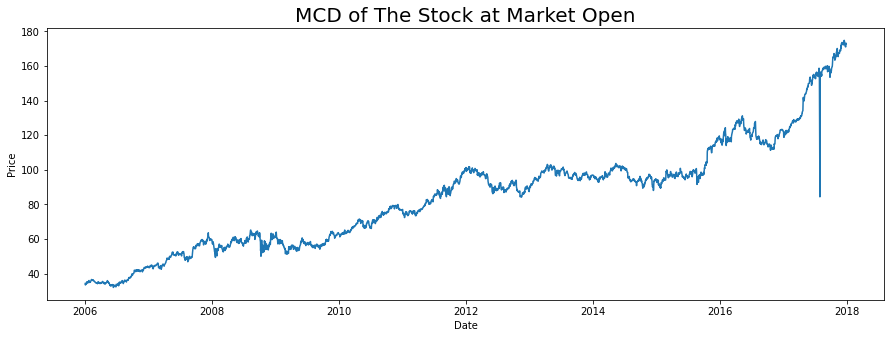

In [85]:
import matplotlib.pyplot as plt

plt.figure(figsize = (15,5))
plt.plot(data)
plt.title('MCD of The Stock at Market Open', fontsize = 20)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

# Membangun Arsitektur Model

In [86]:
# mengubah data menjadi numpy array

X = data['Open'].values

In [112]:
import tensorflow as tf

def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  series = tf.expand_dims(series, axis = -1)
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size + 1, shift = 1, drop_remainder = True)
  ds = ds.flat_map(lambda w: w.batch(window_size + 1))
  ds = ds.shuffle(shuffle_buffer)
  ds = ds.map(lambda w: (w[:-1], w[-1:]))
  return ds.batch(batch_size).prefetch(1)

In [113]:
from sklearn.model_selection import train_test_split

X_train, X_test = train_test_split(X,
                                   test_size = 0.2,
                                   random_state = 0,
                                   shuffle = False)

print(len(X_train), len(X_test))

2416 604


In [114]:
data_X_train = windowed_dataset(X_train, 
                              window_size = 60, 
                              batch_size = 100,
                              shuffle_buffer = 1000)
data_X_test = windowed_dataset(X_test, 
                              window_size = 60, 
                              batch_size = 100,
                              shuffle_buffer = 1000)

In [115]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Bidirectional, Dropout

model = Sequential([
  Bidirectional(LSTM(60, return_sequences = True)),
  Bidirectional(LSTM(20)),
  Dropout(0.5),
  Dense(1), 
  tf.keras.layers.Lambda(lambda x: x * 200)
])

In [116]:
cl = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-5 * 10**(epoch/20))
optimizer = tf.keras.optimizers.SGD(learning_rate = 1e-5, momentum = 0.9)
model.compile(optimizer = optimizer,
              loss = tf.keras.losses.Huber(),
              metrics = ['mae'])

In [117]:
mae = (data['Open'].max() - data['Open'].min()) * 0.1
mae

14.287

In [118]:
# callbacks

class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('mae')< mae):
      self.model.stop_training = True
      print("\nMAE < 10% dari skala data")
callbacks = myCallback()

In [119]:
history = model.fit(data_X_train,
                    epochs = 25,
                    validation_data = data_X_test,
                    callbacks = [callbacks])

Epoch 1/25
24/24 [==============================] - 12s 189ms/step - loss: 51.4945 - mae: 51.9925 - val_loss: 43.0665 - val_mae: 43.5665
Epoch 2/25
24/24 [==============================] - 3s 111ms/step - loss: 26.6702 - mae: 27.1670 - val_loss: 39.4724 - val_mae: 39.9724
Epoch 3/25
24/24 [==============================] - 3s 110ms/step - loss: 15.1206 - mae: 15.6131 - val_loss: 34.0061 - val_mae: 34.5061
Epoch 4/25
24/24 [==============================] - 3s 110ms/step - loss: 12.1216 - mae: 12.6133 - val_loss: 29.9885 - val_mae: 30.4885

MAE < 10% dari skala data


# Evaluasi Model

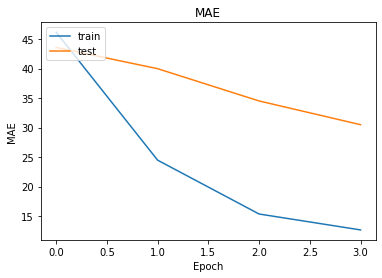

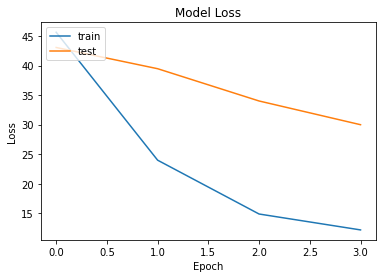

In [120]:
import matplotlib.pyplot as plt

plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('MAE')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc = 'upper left')
plt.show()
  
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc = 'upper left')
plt.show()